In [326]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import precision_recall_curve
from statistics import median
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [327]:
athletes = pd.read_csv('athletes.csv')
athletes

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0


In [328]:
athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [329]:
#У абсолютно всех боксеров отсутвует вес, исключим этот вид спорта из выборки
len(athletes[(athletes['sport'] == 'boxing') & athletes['weight'].isna()]) - len(athletes[athletes['sport'] == 'boxing'])

0

In [330]:
athletes1 = athletes.loc[athletes['sport'] != 'boxing']
athletes1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11252 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11252 non-null  int64  
 1   name         11252 non-null  object 
 2   nationality  11252 non-null  object 
 3   sex          11252 non-null  object 
 4   dob          11251 non-null  object 
 5   height       10933 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11252 non-null  object 
 8   gold         11252 non-null  int64  
 9   silver       11252 non-null  int64  
 10  bronze       11252 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1.0+ MB


In [331]:
#Для каждого пола найдем медианное значение роста/веса
medians = athletes1.groupby(by=['sex'], as_index=False)[['height', 'weight']].median()
medians

,sex,height,weight
0,female,1.70,61.0
1,male,1.82,78.0


In [332]:
#Заполним пустые значения роста/веса на медианное значение
athletes1.loc[(athletes1['height'].isna()) & (athletes1['sex'] == 'male'), ['height'] ] = 1.82
athletes1.loc[(athletes1['height'].isna()) & (athletes1['sex'] == 'female'), ['height'] ] = 1.70
athletes1.loc[(athletes1['weight'].isna()) & (athletes1['sex'] == 'male'), ['weight'] ] = 78.0
athletes1.loc[(athletes1['weight'].isna()) & (athletes1['sex'] == 'female'), ['weight'] ] = 61.0
athletes_final = athletes1.dropna()
athletes_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11251 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11251 non-null  int64  
 1   name         11251 non-null  object 
 2   nationality  11251 non-null  object 
 3   sex          11251 non-null  object 
 4   dob          11251 non-null  object 
 5   height       11251 non-null  float64
 6   weight       11251 non-null  float64
 7   sport        11251 non-null  object 
 8   gold         11251 non-null  int64  
 9   silver       11251 non-null  int64  
 10  bronze       11251 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1.0+ MB


In [333]:
athletes_final

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0


In [334]:
le = LabelEncoder()
athletes_final['sex'] = le.fit_transform(athletes_final['sex'])
transformer = make_column_transformer((OneHotEncoder(), ['nationality', 'sport']), remainder='passthrough', sparse_threshold=0)
transformed = transformer.fit_transform(athletes_final)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
transformed_df

C:\Users\Игнат\AppData\Local\Temp\ipykernel_31100\1405858763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  athletes_final['sex'] = le.fit_transform(athletes_final['sex'])


,onehotencoder__nationality_AFG,onehotencoder__nationality_ALB,onehotencoder__nationality_ALG,onehotencoder__nationality_AND,onehotencoder__nationality_ANG,onehotencoder__nationality_ANT,onehotencoder__nationality_ARG,onehotencoder__nationality_ARM,onehotencoder__nationality_ARU,onehotencoder__nationality_ASA,...,onehotencoder__sport_wrestling,remainder__id,remainder__name,remainder__sex,remainder__dob,remainder__height,remainder__weight,remainder__gold,remainder__silver,remainder__bronze
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,736041664,A Jesus Garcia,1,10/17/69,1.72,64.0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,532037425,A Lam Shin,0,9/23/86,1.68,56.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,435962603,Aaron Brown,1,5/27/92,1.98,79.0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,521041435,Aaron Cook,1,1/2/91,1.83,80.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,33922579,Aaron Gate,1,11/26/90,1.81,71.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,265605954,Zurian Hechavarria,0,8/10/95,1.64,58.0,0,0,0
11247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,214461847,Zuzana Hejnova,0,12/19/86,1.73,63.0,0,0,0
11248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,88361042,di Xiao,1,5/14/91,1.85,100.0,0,0,0
11249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,900065925,le Quoc Toan Tran,1,4/5/89,1.6,56.0,0,0,0


In [394]:
#Можно с высокой долей вероятности утверждать, что у нас сбалансированные классы
transformed_df['remainder__sex'].value_counts()

1    6082
0    5169
Name: remainder__sex, dtype: int64

In [335]:
X = transformed_df.loc[:, ~transformed_df.columns.isin(['remainder__sex', 'remainder__name', 'remainder__dob', 'remainder__id', 'remainder__gold', 'remainder__silver',	'remainder__bronze'])]
y = transformed_df['remainder__sex'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#Логистическая регрессия
log = LogisticRegression().fit(X_train, y_train)

e:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [336]:
# смотрим разницу факта и прогноза для логистической регрессии
result_log = pd.DataFrame([np.array(y_test), log.predict(X_test)]).T
result_log.columns = ['y_test', 'y_pred']
result_log

,y_test,y_pred
0,1,1
1,1,1
2,1,1
3,0,0
4,1,1
...,...,...
2246,1,0
2247,0,0
2248,1,1
2249,0,0


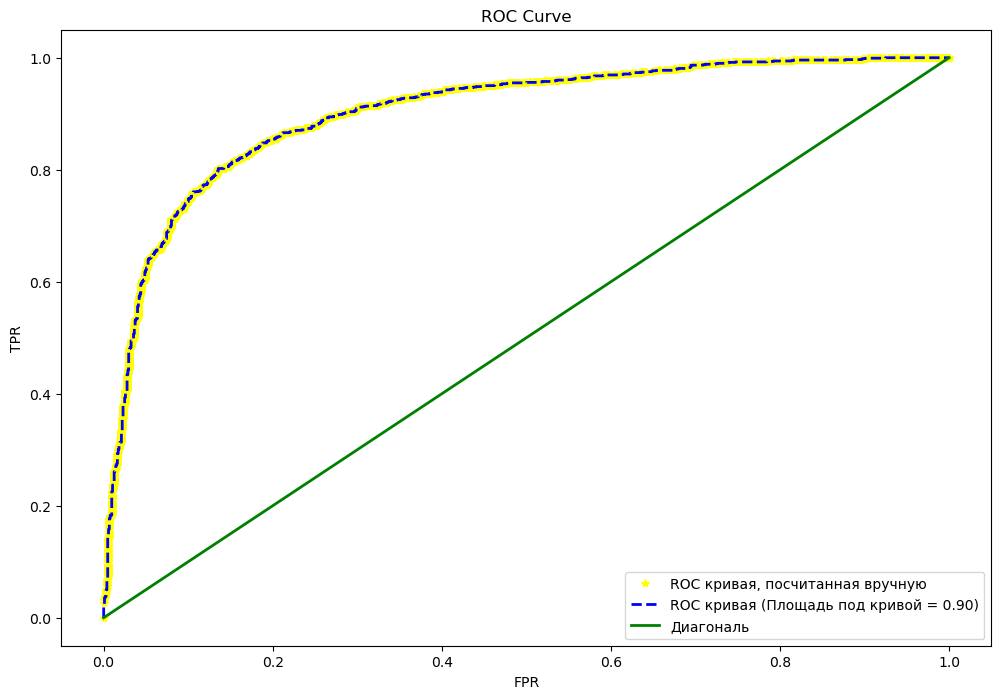

In [379]:
fpr_, tpr_ = [], []

def calculate_metrics(y_pred, y_test, thresholds):
    tp, fp, fn, tn = 0, 0, 0, 0
    for pred, true in zip(y_pred, y_test):
        if pred >= thresholds:
            if true == 1:
                tp += 1
            else:
                fp += 1
        else:
            if true == 1:
                fn += 1
            else:
                tn += 1
    return tp, fp, fn, tn

thresholds_ = np.linspace(0, 1, len(log.predict_proba(X_test)))
for threshold in thresholds_:
    tp_, fp_, fn_, tn_ = calculate_metrics(log.predict_proba(X_test)[:, 1], y_test, threshold)
    fpr_.append(fp_/(fp_ + tn_))
    tpr_.append(tp_/(tp_+ fn_))
    
plt.figure(figsize = (12, 8))
plt.plot(fpr_, tpr_, '*', color='yellow', label='ROC кривая, посчитанная вручную')

roc_auc = roc_auc_score(y_test, log.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, log.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, '--', color='blue', label='ROC кривая (Площадь под кривой = %0.2f)' % roc_auc, linewidth=2)

plt.plot([0, 1], [0, 1], 'g-', label='Диагональ', linewidth=2)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

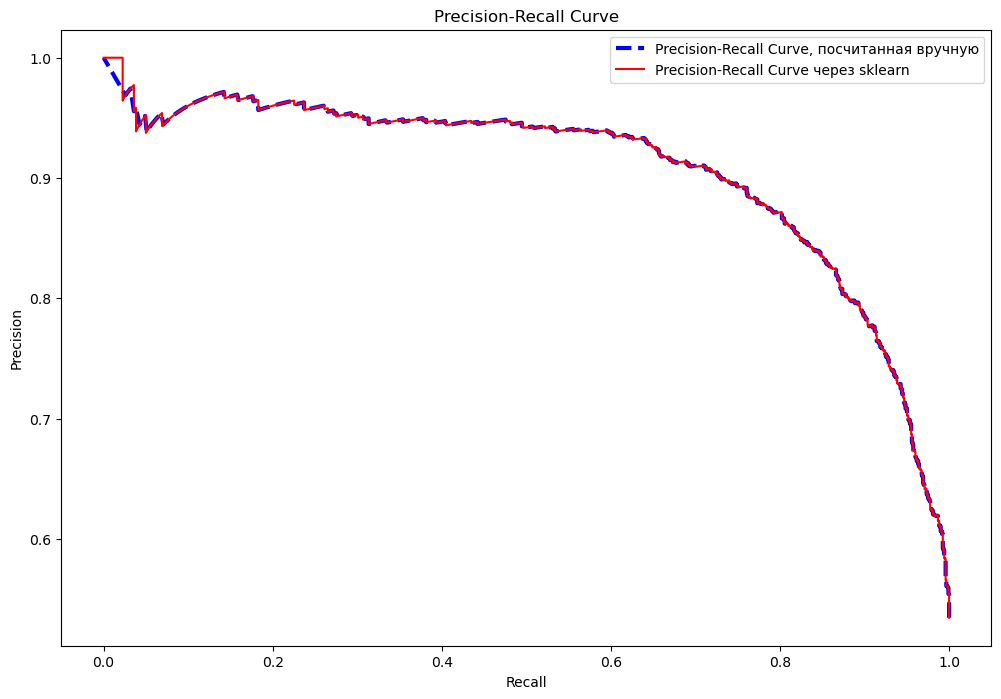

In [356]:
precision, recall = [], []

thresholds_ = np.linspace(0, 1, len(log.predict_proba(X_test)))
for threshold in thresholds_:
    tp_, fp_, fn_, tn_ = calculate_metrics(log.predict_proba(X_test)[:, 1], y_test, threshold)
    try:
        precision.append(tp_/(tp_ + fp_))
    except:
        precision.append(1)
    recall.append(tp_/(tp_ + fn_))
    
plt.figure(figsize = (12, 8))
plt.plot(recall, precision, '--', label='Precision-Recall Curve, посчитанная вручную', color='blue', linewidth=3)

precision_, recall_, thresholds__ = precision_recall_curve(y_test, log.predict_proba(X_test)[:, 1])
plt.plot(recall_, precision_, label='Precision-Recall Curve через sklearn', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

Как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик? Площадь под ROC Curve ближе к 1, чем к 0.5, что свидетельствует о том, что наша модель хорошо справляется с предсказанием классов, которые, между прочим, сбалансированны

может ли ROC-кривая проходить ниже диагонали?
Может, когда положительный класс определяется как отрицательный и наоборот